In [1]:
import numpy as np
import pandas as pd
import matplotlib .pyplot as plt
import seaborn as sns
from sklearn.tree import ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import ExtraTreeRegressor
import pickle
import bz2

In [2]:
train_data=pd.read_csv("Data_Train.csv",index_col=False)
train_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [3]:
train_data.dropna(inplace=True)
train_data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

In [4]:
train_data['journy_day']=pd.to_datetime(train_data.Date_of_Journey,format="%d/%m/%Y").dt.day
train_data['journy_month']=pd.to_datetime(train_data.Date_of_Journey,format="%d/%m/%Y").dt.month
train_data=train_data.drop('Date_of_Journey',axis=1)

In [5]:
train_data['dep_hour']=pd.to_datetime(train_data.Dep_Time).dt.hour
train_data['dep_min']=pd.to_datetime(train_data.Dep_Time).dt.minute
train_data=train_data.drop('Dep_Time',axis=1)

In [6]:
train_data['arrival_hour']=pd.to_datetime(train_data.Arrival_Time).dt.hour
train_data['arrival_min']=pd.to_datetime(train_data.Arrival_Time).dt.minute
train_data=train_data.drop('Arrival_Time',axis=1)

In [7]:
duration=list(train_data.Duration)
for i in range(len(duration)):
    if (len(duration[i].split()) != 2):
        if ('h' in duration[i]):
            duration[i]=duration[i]+' 0m'
        else:
            duration[i]='0h '+ duration[i]
duration_hour=[]
duration_min=[]
for i in range(len(duration)):
    duration_hour.append(int(duration[i].split(sep="h")[0]))
    duration_min.append(int(duration[i].split(sep="m")[0].split()[1]))

train_data['duration_hour']=duration_hour
train_data['duration_min']=duration_min
train_data=train_data.drop('Duration',axis=1)


In [8]:
total_stops=list(train_data.Total_Stops)

for i in range(len(total_stops)):
    if len(total_stops[i].split())!=2:
        total_stops[i]=0
    else:
        total_stops[i]=total_stops[i].split()[0]
train_data['total_stops']=total_stops
train_data=train_data.drop('Total_Stops',axis=1)

In [9]:
airline=train_data.Airline
airline=pd.get_dummies(airline,drop_first=True)

soruce=train_data.Source
soruce=pd.get_dummies(soruce,drop_first=True)

destination=train_data.Destination
destination=pd.get_dummies(destination,drop_first=True)

train_data=pd.concat([train_data,airline,soruce,destination],axis=1)
train_data=train_data.drop(['Airline','Source','Destination','Route','Additional_Info'],axis=1)

print(train_data)


       Price  journy_day  journy_month  dep_hour  dep_min  arrival_hour  \
0       3897          24             3        22       20             1   
1       7662           1             5         5       50            13   
2      13882           9             6         9       25             4   
3       6218          12             5        18        5            23   
4      13302           1             3        16       50            21   
...      ...         ...           ...       ...      ...           ...   
10678   4107           9             4        19       55            22   
10679   4145          27             4        20       45            23   
10680   7229          27             4         8       20            11   
10681  12648           1             3        11       30            14   
10682  11753           9             5        10       55            19   

       arrival_min  duration_hour  duration_min total_stops  ...  \
0               10             

In [10]:
x=train_data.iloc[:,1:]
y=train_data.iloc[:,:1]


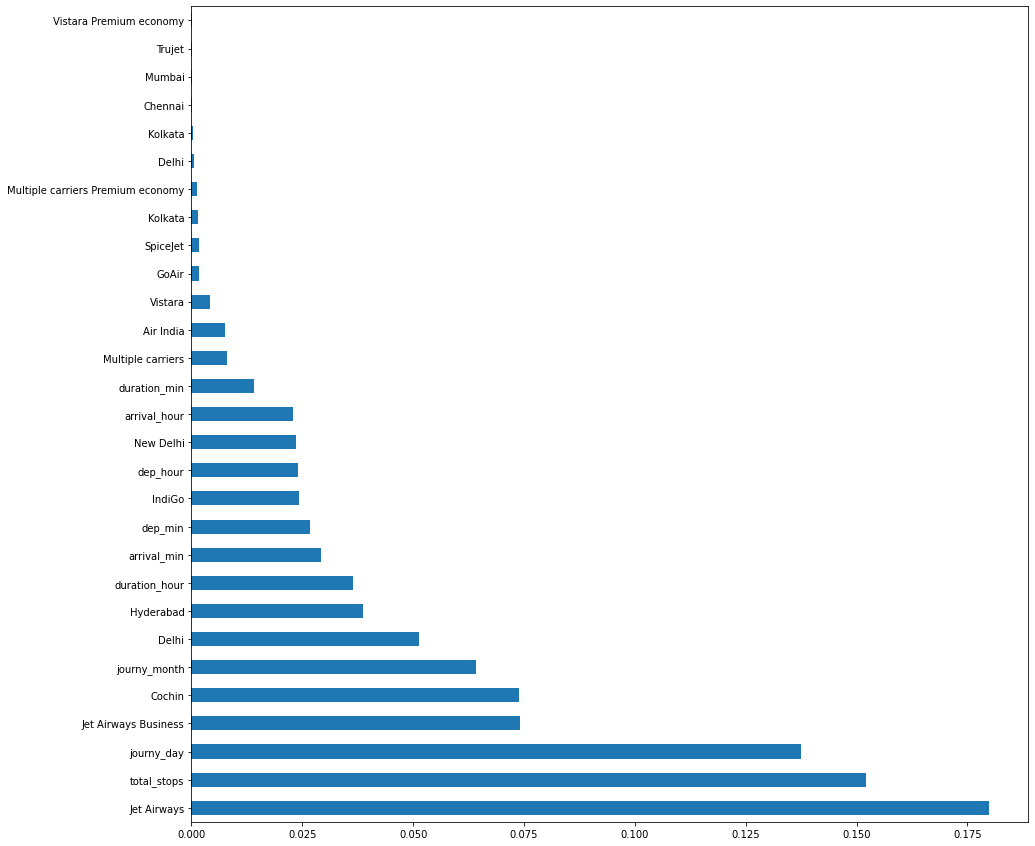

In [11]:
selection=ExtraTreeRegressor()
selection.fit(x,y)

plt.figure(figsize=(15,15))
feature_imp=pd.Series(selection.feature_importances_,index=x.columns)
feature_imp.nlargest(30).plot(kind='barh')
plt.show()

In [12]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=1234)

rf=RandomForestRegressor()
rf.fit(x_train,y_train)
y_pred=rf.predict(x_test)

rf_score_xtest=rf.score(x_test,y_test)
print(rf_score_xtest)




C:\Users\nikhi\AppData\Local\Temp\ipykernel_13328\3627416940.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train,y_train)


0.8061552203718164


In [13]:
n_estimator=[int(x) for x in np.linspace(start=100,stop=1000,num=12)]
max_feature=['auto','sqrt']
max_depth=[int(x) for x in np.linspace(5,30,num=6)]
min_sample_split=[2,5,10,15,50]
min_sample_leaf=[1,2,5,10]


random_grid={
    'n_estimators':n_estimator,
    'max_features':max_feature,
    'max_depth':max_depth,
    'min_samples_split':min_sample_split,
    'min_samples_leaf':min_sample_leaf
}

rf_random=RandomizedSearchCV(estimator=rf,param_distributions=random_grid,n_iter=5,cv=5,random_state=123,n_jobs=-1)
rf_random.fit(x_train,y_train)
rf_param=rf_random.best_params_
rf_pred=rf_random.predict(x_test)
print(rf_param)
rf_score=rf_random.best_score_

rf_score

In [ ]:
file=bz2.BZ2File('flight_prices.pkl','w')
pickle.dump(rf_random,file)
file.close()

model=bz2.BZ2File('flight_prices.pkl','rb')
forest=pickle.load(model)
model.close()

0.8055124768861828
